In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 5)

In [3]:
tickers = ['WEAT', 'CORN', 'SOYB', 'CANE']
end_date = '2023-09-01'

In [4]:
price_dataframe = yf.download(tickers, end=end_date)['Close']

[*********************100%***********************]  4 of 4 completed


In [5]:
preprocessed_dataframe = price_dataframe.fillna(method='ffill')
preprocessed_dataframe = preprocessed_dataframe.dropna()

normalizedDataframe = preprocessed_dataframe.pct_change().dropna()

In [10]:
def getSignal(dataframe, signal, cross_sectional, long_only):

    if cross_sectional:
        signal = pd.DataFrame(signal).rank(axis=1, ascending=True).values

        means = np.mean(signal, axis=1)
        stds = np.std(signal, axis=1)
        normalized_signal = (signal - means[:, np.newaxis]) / stds[:, np.newaxis]
        signal = normalized_signal

        if long_only:
            signal[signal <= 0] = np.nan
            weights = (~np.isnan(signal)).astype(float)
            weights /= np.nansum(weights, axis=1)[:, np.newaxis]
        else:
            positive_signal = np.where(signal > 0, signal, np.nan)
            positive_weights = pd.DataFrame(positive_signal).rank(axis=1, ascending=True).values
            positive_weights /= np.nansum(positive_weights, axis=1)[:, np.newaxis]

            negative_signal = np.where(signal < 0, signal, np.nan)
            negative_weights = pd.DataFrame(negative_signal).rank(axis=1, ascending=False).values
            negative_weights /= np.nansum(negative_weights, axis=1)[:, np.newaxis]

            weights = np.where(signal > 0, positive_weights, negative_weights)
    else:
        if long_only:
            signal[signal <= 0] = np.nan
            weights = (~np.isnan(signal)).astype(float)
            weights /= np.nansum(weights, axis=1)[:, np.newaxis]

        else:
            positive_signal = np.where(signal > 0, signal, np.nan)
            positive_weights = (~np.isnan(positive_signal)).astype(float)
            positive_weights /= np.nansum(positive_weights, axis=1)[:, np.newaxis]

            negative_signal = np.where(signal < 0, signal, np.nan)
            negative_weights = (~np.isnan(negative_signal)).astype(float)
            negative_weights /= np.nansum(negative_weights, axis=1)[:, np.newaxis]

            weights = np.where(signal > 0, positive_weights, negative_weights)

    signal = np.sign(signal)

    return pd.DataFrame(signal * weights, index=dataframe.index, columns=dataframe.columns)

In [7]:
lookbacks = np.arange(2, (21*12*1)+1, 1)
n_splits = 3

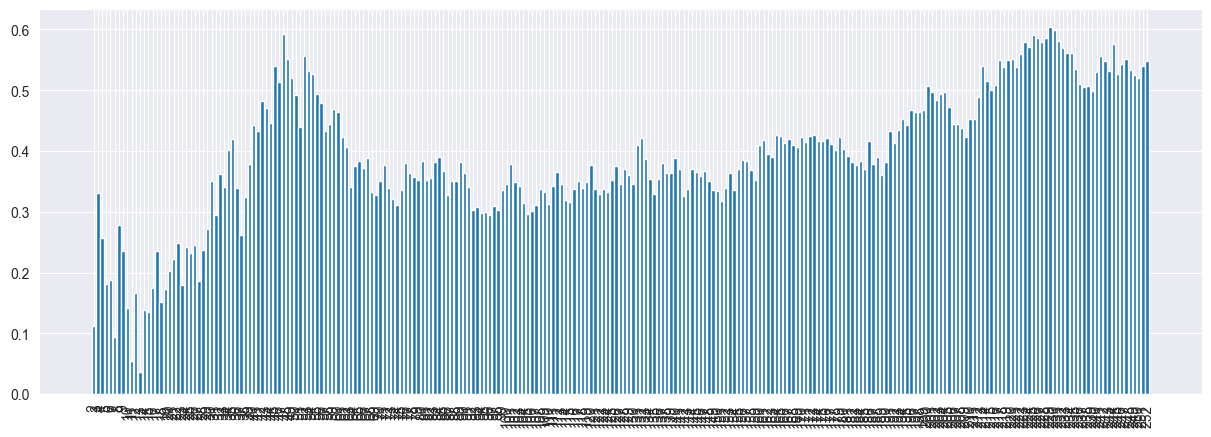

In [30]:
def backtest(dataframe, lookbacks, n_splits):
    splits = len(dataframe) // n_splits
    dataframes = [dataframe.iloc[i * splits:(i + 1) * splits] for i in range(n_splits)]

    sharpes = np.zeros((len(lookbacks), n_splits))

    for i, dataframe in enumerate(dataframes):
        for j, lookback in enumerate(lookbacks):

            signal = (dataframe.rolling(lookback).std().values * -1)
            weighted_signal = getSignal(dataframe, signal, cross_sectional=True, long_only=True)
            portfolio_returns = np.sum(np.roll(weighted_signal, 1, axis=0) * dataframe, axis=1)

            sharpes[j, i] = (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252))

    sharpes = np.average(sharpes, axis=1, weights=np.arange(1, n_splits+1, 1))

    plt.bar(lookbacks, sharpes, tick_label=lookbacks)
    plt.xticks(rotation=90)
    plt.show()

    return np.argmax(sharpes)

highest_sharpe = backtest(normalizedDataframe, lookbacks, n_splits=n_splits)

Best Lookback Window 229
Current weights as a % of portfolio:
CANE    50.0
CORN     0.0
SOYB    50.0
WEAT     0.0
Name: 2023-08-31 00:00:00-04:00, dtype: float64


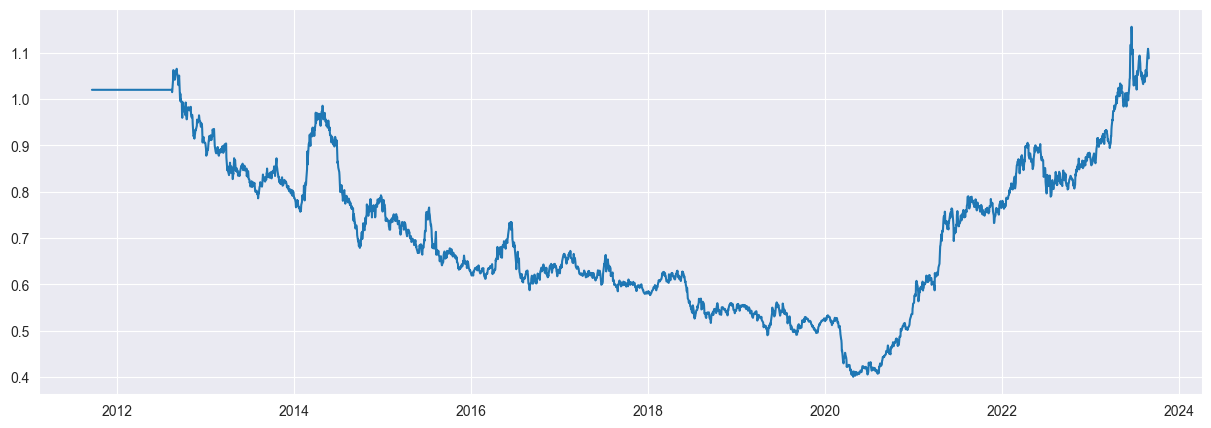

Sharpe: 0.124


In [31]:
def backtest(dataframe, highest_sharpe):
    lookback = lookbacks[highest_sharpe]

    print('Best Lookback Window', lookback)

    signal = (dataframe.rolling(lookback).std().values * -1)
    weighted_signal = getSignal(dataframe, signal, cross_sectional=True, long_only=True)
    weighted_signal.fillna(0, inplace=True)

    print('Current weights as a % of portfolio:')
    print(weighted_signal.iloc[-1] * 100)

    portfolio_returns = np.sum(np.roll(weighted_signal, 1, axis=0) * dataframe, axis=1)

    cumulative_returns = (portfolio_returns + 1).cumprod()
    plt.plot(cumulative_returns)

    plt.show()

    print('Sharpe:', round((portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)), 3))

backtest(normalizedDataframe, highest_sharpe)